---
author: "Robert Ritz"
draft: true
echo: false
---

# Whopper Index

This notebook takes the raw Whopper prices in local currency and the USD exchange rate to calculate the Whopper Index.

To calculate the Whopper Index, we first calculate the implied exchange rate based on the Whopper price locally and in the US. For example:

- In the Czech Republic, a Whopper costs 99 Czech Korunas.

- In the US, a Whopper costs $6.09 USD.

- The implied exchange rate is 99 CZK/USD, which is 99CZK/$6.09USD = 16.25.

From there, we can compare this to the actual exchange rate to see if the currency is over or under-valued. For example:

- The implied exchange rate according to the Whopper index is 16.25 CZK/USD

- The actual exchange rate is 24.61 CZK/USD.

- We can find the currency over/undervaluation between the two by taking: (Implied FX Rate - Actual FX Rate) / Actual FX Rate. (16.25 - 24.61) / 24.61 = -33.9% undervalued

Now let's import our data and calculate the index.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

In [ ]:
df = pd.read_csv('data/whopper_prices.csv')
df.sample(5)

,date,iso_a3,currency_code,currency_name,name,local_price,dollar_ex
14,9/1/2022,HUN,HUF,Forint,Hungary,1590.0,396.42
39,9/1/2022,KOR,KRW,Won,South Korea,6400.0,1381.00
15,9/1/2022,IND,INR,Indian Rupee,India,299.0,79.70
1,9/1/2022,AUS,AUD,Australian Dollar,Australia,9.4,1.48
16,9/1/2022,IDN,IDR,Rupiah,Indonesia,54545.0,14890.02


In [ ]:
df.shape

(49, 7)

### Countries not on the Big Mac Index

Our data contains local prices and USD exchange rates for 50 countries. Notably there are several countries on our list that are not contained in the Big Mac Index. 

In [ ]:
big_mac = pd.read_csv('data/big-mac-raw-index.csv')

In [ ]:
big_mac_countries = list(big_mac[big_mac['date'] == '2022-01-01']['iso_a3'])
whopper_countries = list(df['iso_a3'])

We can see that there are 9 countries on our Whopper list that are not on the Big Mac Index. These include two countries in Central Asia and 3 countries in Africa. 

In [ ]:
extra_countries = list(set(whopper_countries).difference(big_mac_countries))
extra_countries

['MNG', 'NGA', 'KAZ', 'BGD', 'KEN', 'MAR', 'MDV', 'IRQ', 'BLR']

In [ ]:
df[df['iso_a3'].isin(extra_countries)]['name']

3     Bangladesh
4        Belarus
17          Iraq
20    Kazakhstan
21         Kenya
23      Maldives
24      Mongolia
25       Morocco
28       Nigeria
Name: name, dtype: object

In [ ]:
big_mac_2022 = big_mac[big_mac['date'] == '2022-07-01']

In [ ]:
big_mac_2022[big_mac_2022['iso_a3'].isin(list(set(big_mac_countries).difference(whopper_countries)))]['name']

1580                 Bahrain
1584                   Chile
1585                   China
1586                Colombia
1587              Costa Rica
1593                Honduras
1600                  Jordan
1602                 Lebanon
1603                Malaysia
1604                  Mexico
1605                 Moldova
1609                    Oman
1615                 Romania
1620               Sri Lanka
1626    United Arab Emirates
1629               Venezuela
Name: name, dtype: object

## Build Index

Now we can move forward and build the index. First we will calculate the local price in USD at the current exchange. This will help us build a sense of "How many Whoppers can I buy with $50 USD?". This is one of the halmarks of the Economist's Big Mac index, and a very easy way to understand purchasing power parity.

Then we will calculate the implied exchange rate and finally the index.

In [ ]:
us_price = df[df['iso_a3'] == 'USA']['local_price'].iat[0]

In [ ]:
df = (df.assign(dollar_price = lambda x: x['local_price'] / x['dollar_ex'],
                implied_ex = lambda x: x['local_price'] / us_price,
                usd_index = lambda x: round(((x['implied_ex'] - x['dollar_ex']) / x['dollar_ex']) * 100, 2))
        .sort_values(by='usd_index', ignore_index=True)
    )

In [ ]:
df

,date,iso_a3,currency_code,currency_name,name,local_price,dollar_ex,dollar_price,implied_ex,usd_index
0,9/1/2022,ZAF,ZAR,Rand,South Africa,29.90,17.300,1.728324,4.909688,-71.62
1,9/1/2022,PAK,PKR,Pakistan Rupee,Pakistan,540.00,222.740,2.424351,88.669951,-60.19
2,9/1/2022,PHL,PHP,Philippine Peso,Philippines,177.00,57.180,3.095488,29.064039,-49.17
3,9/1/2022,BLR,BYN,Belarussian Ruble,Belarus,7.90,2.520,3.134921,1.297209,-48.52
4,9/1/2022,PER,PEN,Neuvo Sol,Peru,12.90,3.890,3.316195,2.118227,-45.55
5,9/1/2022,MNG,MNT,Tugrik,Mongolia,10900.00,3227.000,3.377750,1789.819376,-44.54
6,9/1/2022,EGY,EGP,Egyptian Pound,Egypt,66.00,19.260,3.426791,10.837438,-43.73
7,9/1/2022,QAT,QAR,Qatari Rial,Qatar,13.00,3.640,3.571429,2.134647,-41.36
8,9/1/2022,IDN,IDR,Rupiah,Indonesia,54545.00,14890.020,3.663192,8956.486043,-39.85
9,9/1/2022,GTM,GTQ,Quetzal,Guatemala,29.00,7.750,3.741935,4.761905,-38.56


In [ ]:
df.to_csv("data/whopper_index.csv", index=False)

## Plot Index

In [ ]:
plt.style.use("datafantic.mplstyle")

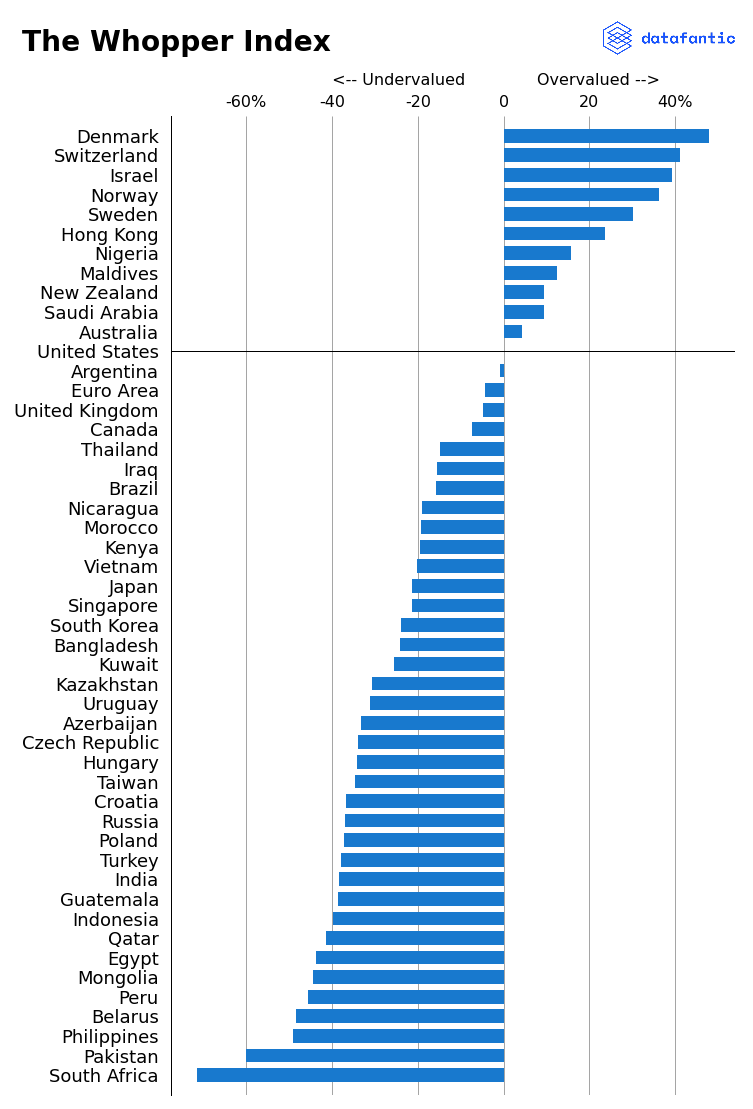

In [ ]:
fig, ax = plt.subplots(figsize=(9, 18))
ax.barh(df['name'], df['usd_index'], height=0.7, linewidth=1)

# Add horizontal line where the US is
ax.axhline(37, color='black', linewidth=1)

# Move x axis to top and change tick labels
ax.xaxis.tick_top()
ax.tick_params(axis='x', 
               which='major', 
               labelsize=16, 
               top=False, 
               pad=1)
ax.set_xticks(np.arange(-60, 60, 20), labels=['-60%', '-40','-20','0', '20', '40%'])

ax.set_xlabel("                 <-- Undervalued              Overvalued -->", 
              labelpad=10, 
              fontsize=16)
ax.xaxis.set_label_position('top') 

# Change grid and font sizes
ax.grid(False)
ax.grid(True, which='major', axis='x')
ax.spines.bottom.set_visible(False)

# Shrink y axis
ax.set_ylim(-1, df.shape[0])

# Add in title and subtitle
ax.text(x=-0.15, y=.93, 
        s="The Whopper Index", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        fontweight='bold')
        

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, 
                    xy=(1,1.1), 
                    xycoords='axes fraction', 
                    box_alignment=(1,1), 
                    frameon = False)
ax.add_artist(ab)


# Export plot as high resolution PNG
plt.savefig('images/whopper_index.png')

## Compare to Big Mac Index

The Big Mac Index isn't a perfect measure of PPP, and neither is our Whopper Index. However, by comparing them we might find useful differences to interpret. We will plot the 

In [ ]:
big_mac = big_mac.rename(columns={'dollar_price':'big_mac_dollar_price'})

In [ ]:
compare = (df.merge(big_mac[big_mac['date'] == '2022-07-01'][['iso_a3','USD','big_mac_dollar_price']], how='left', on='iso_a3')
             .rename(columns={'USD':'big_mac_index'})
             .dropna()
             .reset_index(drop=True)
             .assign(big_mac_index = lambda x: round(x['big_mac_index'] * 100, 2))
)

In [ ]:
compare.head()

,date,iso_a3,currency_code,currency_name,name,local_price,dollar_ex,dollar_price,implied_ex,usd_index,big_mac_index,big_mac_dollar_price
0,9/1/2022,ZAF,ZAR,Rand,South Africa,29.9,17.30,1.728324,4.909688,-71.62,-54.52,2.342065
1,9/1/2022,PAK,PKR,Pakistan Rupee,Pakistan,540.0,222.74,2.424351,88.669951,-60.19,-38.70,3.156708
2,9/1/2022,PHL,PHP,Philippine Peso,Philippines,177.0,57.18,3.095488,29.064039,-49.17,-46.51,2.754821
3,9/1/2022,PER,PEN,Neuvo Sol,Peru,12.9,3.89,3.316195,2.118227,-45.55,-30.67,3.570649
4,9/1/2022,EGY,EGP,Egyptian Pound,Egypt,66.0,19.26,3.426791,10.837438,-43.73,-52.85,2.428081


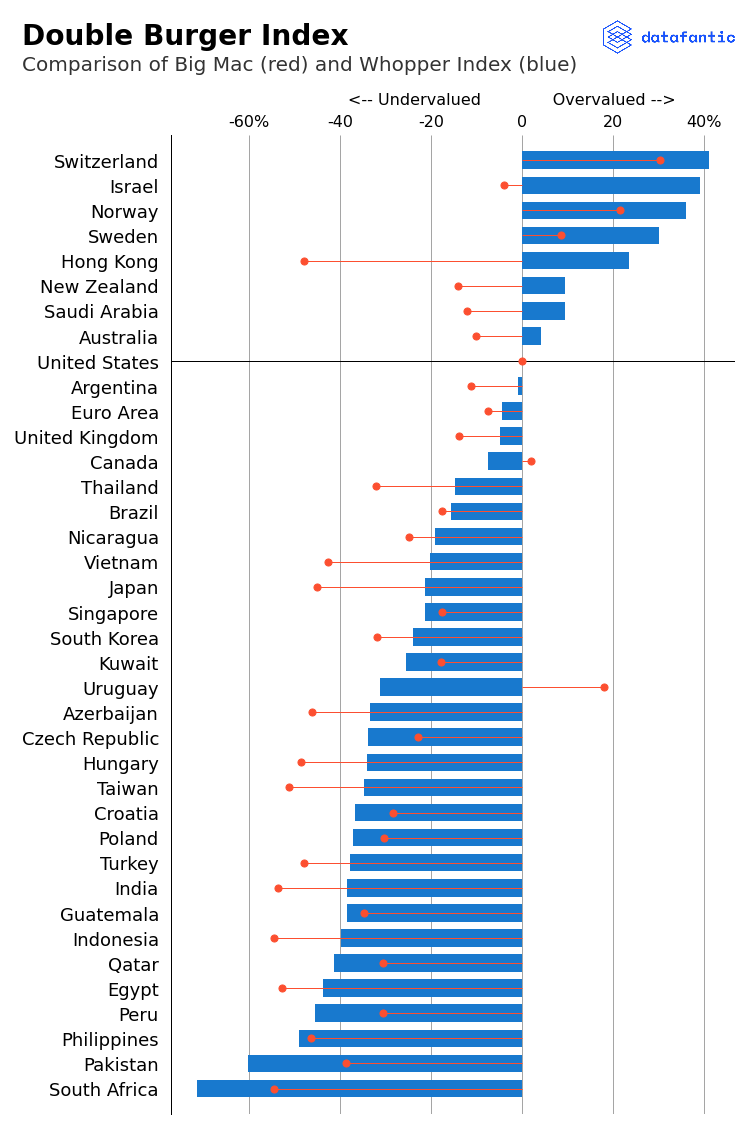

In [ ]:
fig, ax = plt.subplots(figsize=(9, 18))
ax.barh(compare['name'], compare['usd_index'], height=0.7, linewidth=1, zorder=1)

# Add in Big Mac Index data
ax.hlines(y=compare.index, 
          xmin=[0] * compare.shape[0], 
          xmax=compare['big_mac_index'], 
          color='#FC4F30', 
          zorder=2, 
          linewidth=1, 
          label='_nolegend_')
ax.scatter(compare['big_mac_index'], np.arange(compare.shape[0]), s=50, zorder=3)


# Add horizontal line where the US is
ax.axhline(29, color='black', linewidth=1)

# Move x axis to top and change tick labels
ax.xaxis.tick_top()
ax.tick_params(axis='x', 
               which='major', 
               labelsize=16, 
               top=False, 
               pad=1)
ax.set_xticks(np.arange(-60, 60, 20), labels=['-60%', '-40','-20','0', '20', '40%'])

ax.set_xlabel("                       <-- Undervalued              Overvalued -->", 
              labelpad=10, 
              fontsize=16)
ax.xaxis.set_label_position('top') 

# Change grid and font sizes
ax.grid(False)
ax.grid(True, which='major', axis='x')
ax.spines.bottom.set_visible(False)

# Shrink y axis
ax.set_ylim(-1, compare.shape[0])

# Add in title and subtitle
ax.text(x=-0.15, y=.95, 
        s="Double Burger Index", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        fontweight='bold')
ax.text(x=-0.15, y=.93, 
        s="Comparison of Big Mac (red) and Whopper Index (blue)", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=0.8)
        

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, 
                    xy=(1,1.12), 
                    xycoords='axes fraction', 
                    box_alignment=(1,1), 
                    frameon = False)
ax.add_artist(ab)


# Export plot as high resolution PNG
plt.savefig('images/index_comparison.png')

### Comparing Whopper and Big Mac Prices

My wife (a very smart lady), brought an idea to my attention. While these indices are comparable, we can also compare the price of Big Macs and Whoppers directly. My main concern here is that the prices I'm collecting often come from delivery services. This might be skewing things enough to cause problems.

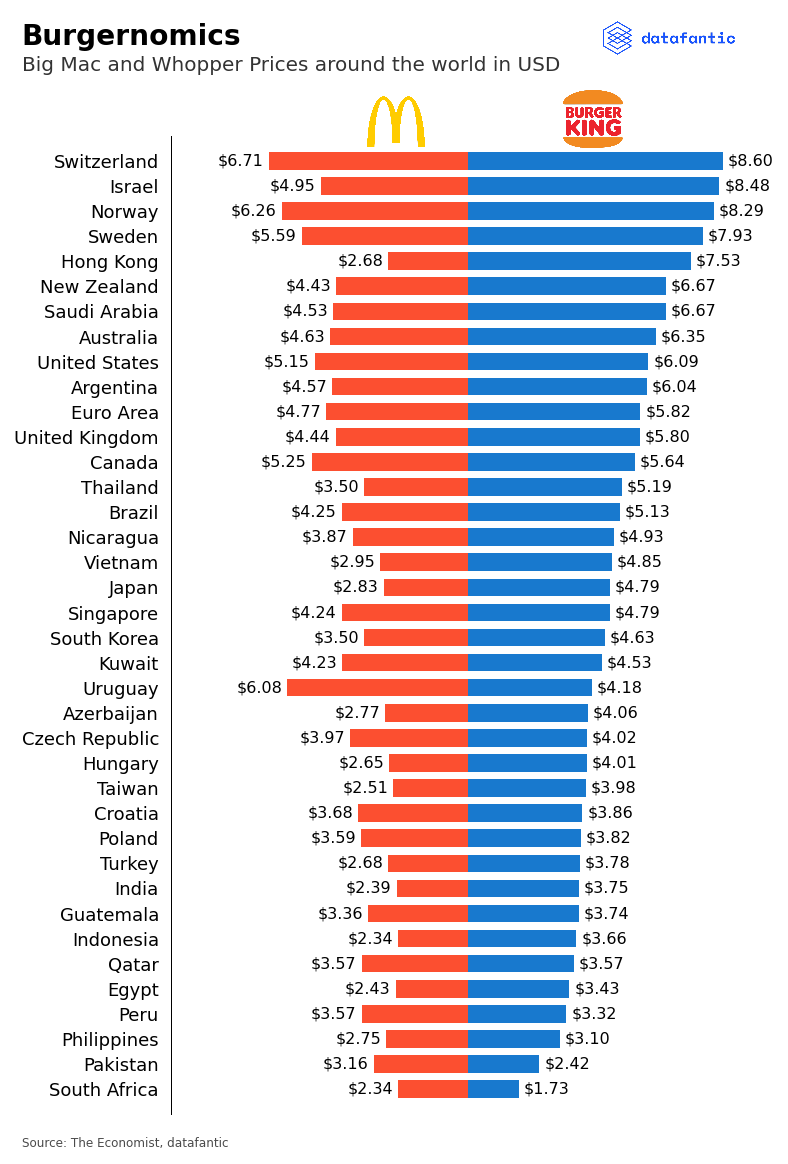

In [ ]:
fig, ax = plt.subplots(figsize=(9, 18))
bar1 = ax.barh(compare['name'], compare['dollar_price'].round(2), height=0.7, linewidth=1, zorder=1)
bar2 = ax.barh(compare['name'], -compare['big_mac_dollar_price'].round(2), height=0.7, linewidth=1, zorder=1)

ax.bar_label(bar1, padding=5, fmt='$%.2f', fontsize=16)
ax.bar_label(bar2, padding=5, labels=['$%.2f' % np.absolute(e) for e in compare['big_mac_dollar_price']], fontsize=16)

# Move x axis to top and change tick labels
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# Change grid and font sizes
ax.grid(False)
ax.grid(True, which='major', axis='x')
ax.spines.bottom.set_visible(False)

# Shrink y axis and expand x axis
ax.set_ylim(-1, compare.shape[0])
ax.set_xlim(-10, 9)

# Change grid and font sizes
ax.grid(False)
ax.spines.bottom.set_visible(False)

# Add in title and subtitle
ax.text(x=-0.15, y=.95, 
        s="Burgernomics", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        fontweight='bold')
ax.text(x=-0.15, y=.93, 
        s="Big Mac and Whopper Prices around the world in USD", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=0.8)

# Add McDonalds and Burger King Logo
bk_logo = plt.imread('images/burger_king_logo.png')
imagebox = OffsetImage(bk_logo, zoom=.12)
ab = AnnotationBbox(imagebox, 
                    xy=(.8,1.046), 
                    xycoords='axes fraction', 
                    box_alignment=(1,1), 
                    frameon = False)
ax.add_artist(ab)

mc_logo = plt.imread('images/mcdonalds_logo.png')
imagebox = OffsetImage(mc_logo, zoom=.03)
ab = AnnotationBbox(imagebox, 
                    xy=(.45,1.04), 
                    xycoords='axes fraction', 
                    box_alignment=(1,1), 
                    frameon = False)
ax.add_artist(ab)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, 
                    xy=(1,1.12), 
                    xycoords='axes fraction', 
                    box_alignment=(1,1), 
                    frameon = False)
ax.add_artist(ab)

# Set source text
ax.text(x=-0.15, y=0.1, 
        s="""Source: The Economist, datafantic""", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=12, 
        alpha=.7)



# Export plot as high resolution PNG
plt.savefig('images/price_comparison.png')

## Most Expensive Whoppers

Let's take a look at the most expensive Whoppers.

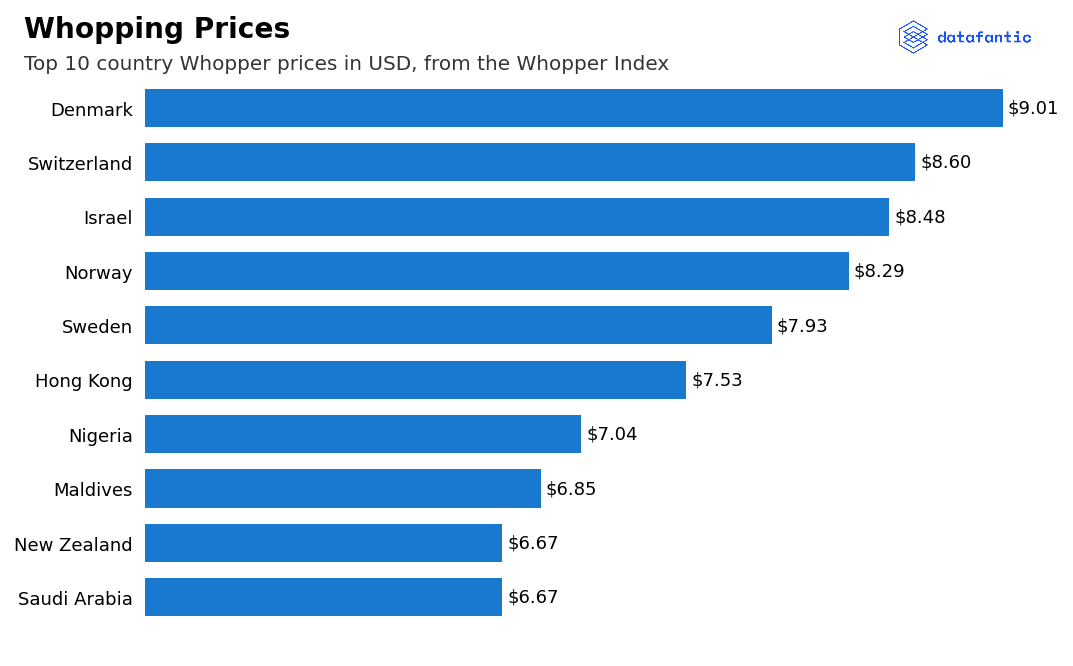

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
bar1 = ax.barh(df['name'][-10:], df['dollar_price'][-10:].round(2), height=0.7, linewidth=1, zorder=1)
ax.bar_label(bar1, padding=5, fmt='$%.2f', fontsize=18)

# Add horizontal line where the US is
ax.axhline(29, color='black', linewidth=1)

# Move x axis to top and change tick labels
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# Shrink y axis
ax.set_ylim(-1, df[-10:].shape[0])
ax.set_xlim(5, 9.1)

# Change grid and font sizes
ax.grid(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Add in title and subtitle
ax.text(x=-0.04, y=.9, 
        s="Whopping Prices", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        fontweight='bold')
ax.text(x=-0.04, y=.86, 
        s="Top 10 country Whopper prices in USD, from the Whopper Index", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, xy=(1.01,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/top_whopper_prices.png')

## Now let's look at the cheapest Whoppers

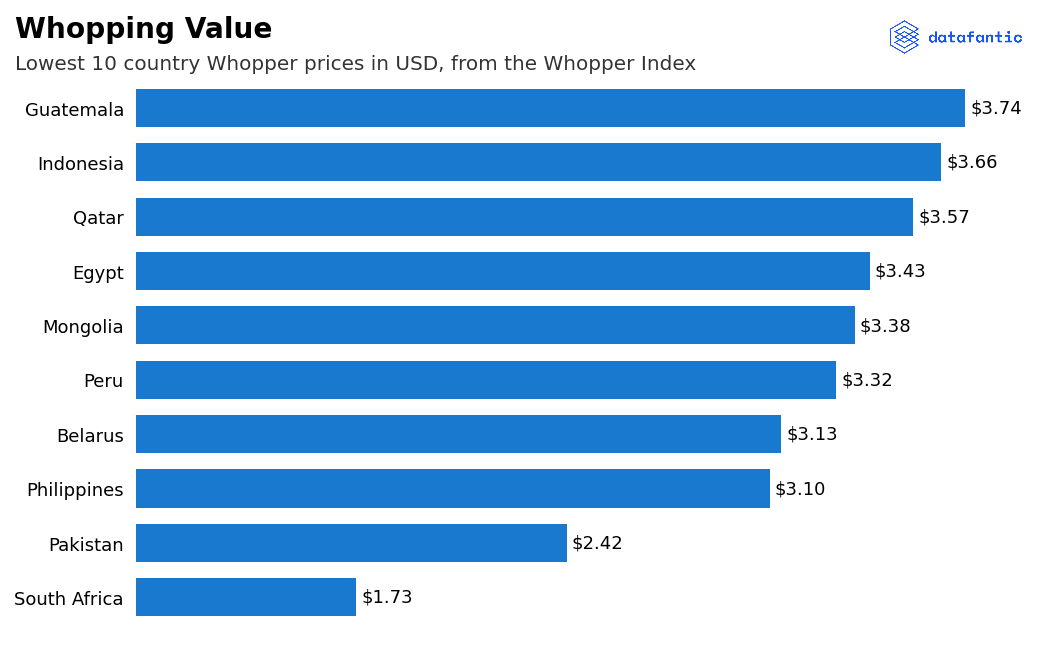

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
bar1 = ax.barh(df['name'][:10], df['dollar_price'][:10], height=0.7, linewidth=1, zorder=1)
ax.bar_label(bar1, padding=5, fmt='$%.2f', fontsize=18)

# Add horizontal line where the US is
ax.axhline(29, color='black', linewidth=1)

# Move x axis to top and change tick labels
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

# Shrink y axis
ax.set_ylim(-1, df[:10].shape[0])
ax.set_xlim(1, 3.9)

# Change grid and font sizes
ax.grid(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Add in title and subtitle
ax.text(x=-0.04, y=.9, 
        s="Whopping Value", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=28, 
        fontweight='bold')
ax.text(x=-0.04, y=.86, 
        s="Lowest 10 country Whopper prices in USD, from the Whopper Index", 
        transform=fig.transFigure, 
        ha='left', 
        fontsize=20, 
        alpha=.8)

# Set the logo
logo = plt.imread('images/datafantic.png')
imagebox = OffsetImage(logo, zoom=.22)
ab = AnnotationBbox(imagebox, xy=(1.01,1.06), xycoords='axes fraction', box_alignment=(1,1), frameon = False)
ax.add_artist(ab)

# Export plot as high resolution PNG
plt.savefig('images/bottom_whopper_prices.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70230ccc-7ca7-41b6-947f-bad4c8d5dfa6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>